#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import lightgbm as lgb
import lightgbm
import time 

from catboost import CatBoostRegressor
from catboost import cv
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn. model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingRegressor

from numpy import mean
from numpy import absolute
from numpy import sqrt

RANDOMSTATE = 12345
FIGSIZE = figsize=(16, 5)
TSCV = TimeSeriesSplit(n_splits = 5)

Подключил библиотеки и определил переменные.

In [2]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

Загрузил датасет и сохранил его в переменной data.

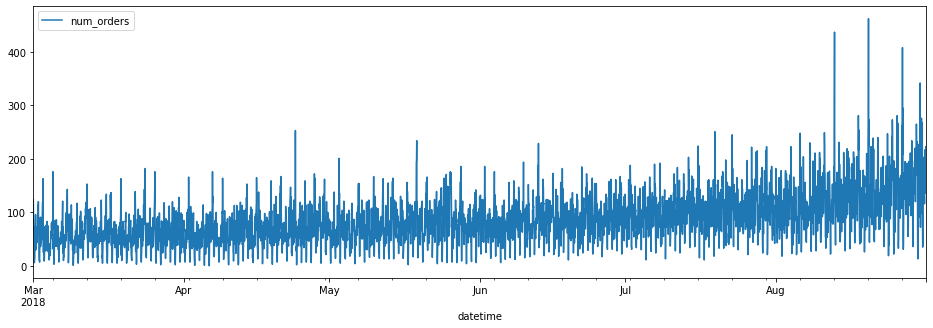

In [3]:
data = data.resample('1H').sum()
data.plot(figsize = FIGSIZE);

Выполнил ресемплирование и построил график временного ряда за весь период.

### Вывод

В первой части своего проекта, я подключил необходимые для работы библиотеки, загрузи данные и выполнил ресемплирование данных по одному часу, построил график временного рядя.

## 2. Анализ

In [4]:
print(data.index.is_monotonic)

True


Проверил, что индекс монотонный.

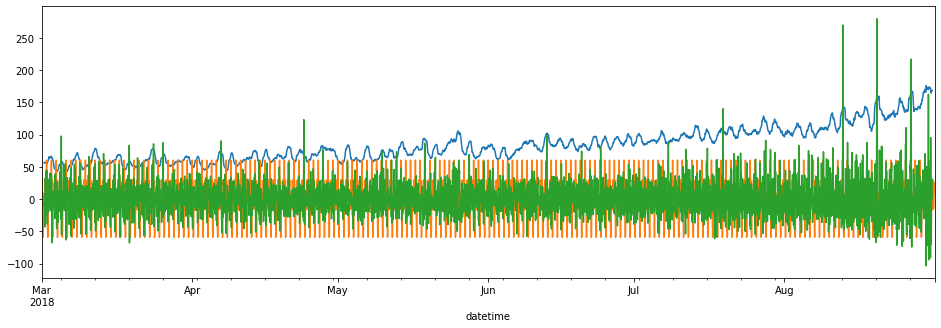

In [5]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize = figsize);
decomposed.seasonal.plot(figsize = figsize);
decomposed.resid.plot(figsize = figsize);

Проверил тренды сезонности заказов, из графика видно, что составляющая trend возрастает а у resid есть всплески.

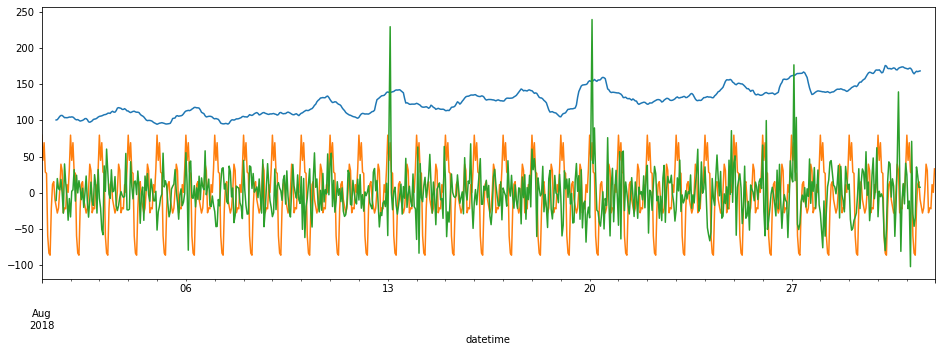

In [6]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-31'])
decomposed.trend.plot(figsize = FIGSIZE)
decomposed.seasonal.plot(figsize = FIGSIZE)
decomposed.resid.plot(figsize = FIGSIZE);

Проверил тренды сезонности заказов за август, из графика видно, что составляющая trend возрастает.

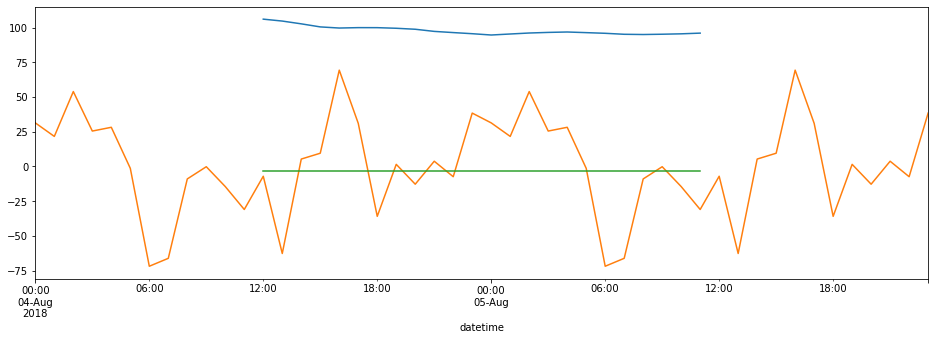

In [7]:
decomposed = seasonal_decompose(data['2018-08-4':'2018-08-5'])
decomposed.trend.plot(figsize = FIGSIZE);
decomposed.seasonal.plot(figsize = FIGSIZE);
decomposed.resid.plot(figsize = FIGSIZE);

Проверил тренды сезонности заказов в выходные 4 и 5 августа сильно меняется seasonal составляющая, сравню этот график с выходными 11-12 августа а потом проведу сравниение с рабочими днями.

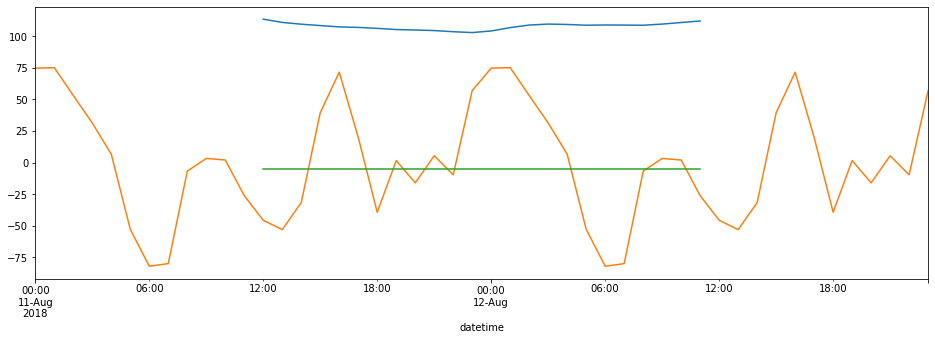

In [8]:
decomposed = seasonal_decompose(data['2018-08-11':'2018-08-12'])
decomposed.trend.plot(figsize = FIGSIZE);
decomposed.seasonal.plot(figsize = FIGSIZE);
decomposed.resid.plot(figsize = FIGSIZE);

График очень похож на график в выходные 4 и 5 августа.

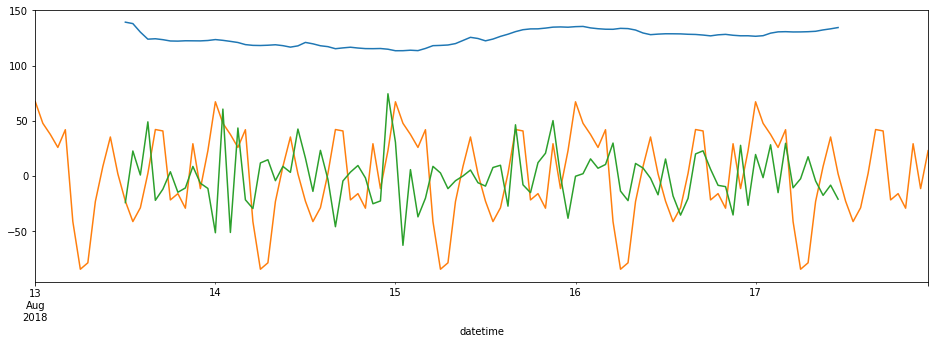

In [9]:
decomposed = seasonal_decompose(data['2018-08-13':'2018-08-17'])
decomposed.trend.plot(figsize = FIGSIZE);
decomposed.seasonal.plot(figsize = FIGSIZE);
decomposed.resid.plot(figsize = FIGSIZE);

График рабочей недели с 13 по 17 августа.

### Вывод

Из построенных графки я делаю вывод, что:  
- в течение рабочего дня изменяется сезонность на графике присутствуют пики в начале и конце рабочего дня;  
- в выходные дни самый большой пик приходится на вечернее и ночное время;
- в течение недели тренд меняется слабо, относительно других показателей.  

## 3. Обучение

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 50, 100)

In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=RANDOMSTATE)
train = train.dropna()

Разбил датасет на две выборки обучающую и тестовую, для тестовой выборки выделил 10% данных.

In [12]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

Выделил признаки для train и test.

In [13]:
print('features_train', features_train.shape)
print('target_train', target_train.shape)
print('features_test', features_test.shape)
print('target_test', target_test.shape)

features_train (3874, 55)
target_train (3874,)
features_test (442, 55)
target_test (442,)


Просмотрел информацию о количестве наблюдений и признаков в каждой таблице.

### 3.1 GradientBoostingRegressor

In [15]:
%%time

model_1 = GradientBoostingRegressor()
model_1 = cross_val_score(model_1, features_train, target_train, cv = TSCV, scoring='neg_root_mean_squared_error')

print('Значение RMSE для GradientBoostingRegressor: {: 0.2f}'.format(-np.average(model_1)))

Значение RMSE для GradientBoostingRegressor:  25.06
CPU times: total: 6.34 s
Wall time: 6.34 s


### 3.2 CatBoostRegressor

In [16]:
%%time

model_2 = CatBoostRegressor()
hyperparams = {
    'random_state':[RANDOMSTATE],
    'learning_rate': [0.1, 0.01],
    'depth': [6, 8, 10],
    'iterations': [40, 60],
}
model_2 = GridSearchCV(model_2, hyperparams, cv = TSCV, scoring='neg_root_mean_squared_error')
model_2.fit(features_train, target_train)
model_2.best_estimator_.fit(features_train, target_train)

print('Значение RMSE для CatBoostRegressor: {: 0.2f}'.format(-model_2.best_score_))

0:	learn: 27.8729493	total: 140ms	remaining: 5.47s
1:	learn: 26.7465632	total: 144ms	remaining: 2.73s
2:	learn: 25.7681866	total: 147ms	remaining: 1.82s
3:	learn: 24.9049067	total: 151ms	remaining: 1.35s
4:	learn: 24.1649711	total: 154ms	remaining: 1.08s
Значение RMSE для CatBoostRegressor:  24.87
CPU times: total: 7min 43s
Wall time: 1min 31s


### 3.3 LGBMRegressor

In [17]:
%%time

model_3 = LGBMRegressor()
hyperparams = {
    'num_leaves':[5, 50, 100],
    'learning_rate': [0.1, 0.01],
    'random_state':[RANDOMSTATE],
}
   
model_3 = GridSearchCV(model_3, hyperparams, cv = TSCV, scoring = 'neg_root_mean_squared_error')
model_3.fit(features_train, target_train)
model_3.best_estimator_.fit(features_train, target_train)

print('Значение RMSE для lightGBM: {: 0.2f}'.format(-model_3.best_score_))

Значение RMSE для lightGBM:  24.49
CPU times: total: 20.3 s
Wall time: 3.42 s


### 3.4 DecisionTreeRegressor

In [18]:
%%time

model_4 = DecisionTreeRegressor()
hyperparams = {
    'max_depth': range(1, 10),
    'random_state':[RANDOMSTATE],
}

model_4 = GridSearchCV(model_4, hyperparams, cv = TSCV, scoring='neg_root_mean_squared_error')
model_4.fit(features_train, target_train)
model_4.best_estimator_.fit(features_train, target_train)

print('Значение RMSE для DecisionTreeRegressor: {: 0.2f}'.format(-model_4.best_score_))

Значение RMSE для DecisionTreeRegressor:  29.02
CPU times: total: 1.73 s
Wall time: 1.26 s


### 3.5 LinearRegression

In [19]:
%%time

model_5 = LinearRegression()
model_5.fit(features_train, target_train)
model_lr = cross_val_score(model_5, features_train, target_train, cv = TSCV, scoring = 'neg_root_mean_squared_error').mean()

print('Значение RMSE для LinearRg: {: 0.2f}'.format(-model_lr))

Значение RMSE для LinearRg:  25.18
CPU times: total: 109 ms
Wall time: 40 ms


### Вывод

В данной части своего проекта я обучил пять моделей, результаты RMSE вывел в сводную таблицу.

In [20]:
df = pd.DataFrame({ 'Param':['Best_score'],
                    'GB':[-np.average(model_1)],
                    'CatBoost':[-model_2.best_score_],
                    'lightGBM':[-model_3.best_score_],
                    'DecisionTreeReg':[-model_4.best_score_],
                    'LR':[-model_lr]
                })
df

,Param,GB,CatBoost,lightGBM,DecisionTreeReg,LR
0,Best_score,25.060486,24.868227,24.486069,29.021681,25.181162


Для проверки на тестовой выборке возьму LinearRegression.

## Тестирование

In [22]:
%%time

model_6 = LinearRegression()
model_6.fit(features_train, target_train)
model_6_predict = model_6.predict(features_test)

print('Значение RMSE для LinearRg на тестовой выборке: {: 0.2f}'.format(mean_squared_error(target_test, model_6_predict)**0.5))

Значение RMSE для LinearRg на тестовой выборке:  43.65
CPU times: total: 46.9 ms
Wall time: 9.03 ms


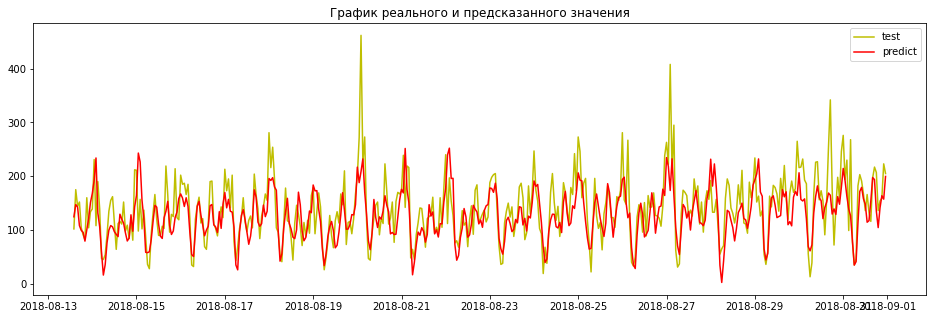

In [23]:
plt.figure(figsize = FIGSIZE)
plt.title('График реального и предсказанного значения')
plt.plot(target_test.index, target_test, 'y', label = 'test')
plt.plot(target_test.index, model_6_predict, 'r', label = 'predict')
plt.legend()
plt.show() 